In [3]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [4]:
#data must be downloaded and path provided
data_path = 'mit-bih-arrhythmia-database-1.0.0/'

In [5]:
#list of patients
pts=['100','101','102','103','104','105','106','107','108','109','111','112','113',
     '114','115','116','117','118','119','121','122','123','124','200','201','202',
     '203','205','207','208','209','210','212','213','214','215','217','219','220',
     '221','222','223','228','230','231','232','233','234']

In [6]:
import wfdb

In [7]:
df=pd.DataFrame()

In [8]:
for pt in pts:
    file=data_path+pt
    annotation=wfdb.rdann(file,'atr')
    sym=annotation.symbol
    
    values,counts=np.unique(sym,return_counts=True)
    df_sub=pd.DataFrame({'sym':values,'val':counts,'pt':[pt]*len(counts)})
    df=pd.concat([df,df_sub],axis=0)
df.head()

,sym,val,pt
0,+,1,100
1,A,33,100
2,N,2239,100
3,V,1,100
0,+,1,101


In [9]:
df.groupby('sym').val.sum().sort_values(ascending=False)


sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [10]:
#list of nonbeat and abnormal
#'`',
nonbeat=['[','!',']','x','(',')','p','t,'u'','`',
         '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal=['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [11]:
#break into normal, abnormal or non-beat
df['cat']=-1
df.loc[df.sym=='N','cat']=0
df.loc[df.sym.isin(abnormal),'cat']=1

In [12]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [13]:
def load_ecg(file):
    #load the ecg
    #example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    #load the ecg
    record=wfdb.rdrecord(file)
    #load the annotation
    annotation=wfdb.rdann(file,'atr')
    
    #extract the signal
    p_signal=record.p_signal
    
    #verify freqency is 360
    assert record.fs==360,'sample freq is not 360'
    
    #extract symbols and annotation index
    atr_sym=annotation.symbol
    atr_sample=annotation.sample
    
    return p_signal, atr_sym, atr_sample


In [14]:
file=data_path+pts[0]


In [15]:
p_signal,atr_sym,atr_sample=load_ecg(file)

In [16]:
values,counts=np.unique(sym,return_counts=True)
for v,c in zip(values,counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [17]:
#get abnormal beat index
ab_index=[b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [18]:
x=np.arange(len(p_signal))

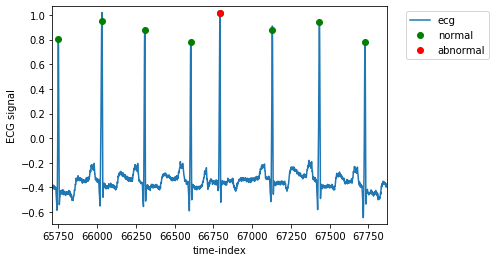

In [19]:
left=ab_index[1]-1080
right=ab_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time-index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show()

In [20]:
#Make a dataset
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'
    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [21]:
#Lesson 1: split on patients not on samples
num_sec = 3
fs = 360
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [22]:
from sklearn.model_selection import train_test_split
X_train,x_valid,y_train,y_valid=train_test_split(X_all,Y_all,test_size=0.33,random_state=42)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Flatten,Dropout
from keras.utils import to_categorical



Using TensorFlow backend.


In [24]:
#build the same model'
#lets test out relu(a diff activation fuc) and drop out(for regularization)
model=Sequential()
model.add(Dense(32,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(rate=0.25))
model.add(Dense(1,activation='sigmoid'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [25]:
#compile the model - use categorical crossentropy and the adam optimiser
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
model.fit(X_train,y_train,batch_size=32,epochs=5,verbose=1)


Epoch 1/5
73096/73096 [==============================] - 5s 67us/step - loss: 0.2467 - accuracy: 0.9085
Epoch 2/5
73096/73096 [==============================] - 5s 62us/step - loss: 0.1652 - accuracy: 0.9461
Epoch 3/5
73096/73096 [==============================] - 5s 65us/step - loss: 0.1449 - accuracy: 0.9547
Epoch 4/5
73096/73096 [==============================] - 5s 62us/step - loss: 0.1308 - accuracy: 0.9594
Epoch 5/5
73096/73096 [==============================] - 5s 62us/step - loss: 0.1257 - accuracy: 0.9611


In [27]:
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score


In [28]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))
def calc_specificity(y_actual,y_pred,thresh):
    #caluculate specificity
    return sum((y_pred<thresh)&(y_actual==0))/sum(y_actual==0)
def print_report(y_actual,y_pred,thresh):
    auc=roc_auc_score(y_actual,y_pred)
    accuracy=accuracy_score(y_actual,(y_pred>thresh))
    recall=recall_score(y_actual,(y_pred>thresh))
    precision=precision_score(y_actual,(y_pred>thresh))
    specificity=calc_specificity(y_actual,y_pred,thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc,accuracy,recall,precision,specificity

In [30]:
y_train_preds_dense=model.predict_proba(X_train,verbose=1)
y_valid_preds_dense=model.predict_proba(x_valid,verbose=1)

36003/36003 [==============================] - 1s 22us/step


In [31]:
thresh=(sum(y_train)/len(y_train))[0]
thresh

0.3147641457808909

In [32]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)

Train
AUC:0.993
accuracy:0.973
recall:0.958
precision:0.956
specificity:0.980
prevalence:0.315
 


(0.9931147479983212,
 0.9728028893509905,
 0.9576234353268428,
 0.9560444328733837,
 array([0.97977559]))

In [33]:
print('Valid')
print_report(y_valid,y_valid_preds_dense,thresh)

Valid
AUC:0.989
accuracy:0.967
recall:0.947
precision:0.946
specificity:0.975
prevalence:0.314
 


(0.9889654430520602,
 0.966530566897203,
 0.9473264872521246,
 0.9460701971532137,
 array([0.97531064]))

In [34]:
import random
random.seed(42)
pts_train=random.sample(pts,36)
pts_valid=[pt for pt in pts if pt not in pts_train]
print(len(pts_train),len(pts_valid))

36 12


In [35]:
X_train,y_train,sym_train=make_dataset(pts_train,num_sec,fs,abnormal)
X_valid,y_valid,sym_valid=make_dataset(pts_valid,num_sec,fs,abnormal)

print(X_train.shape,y_train.shape,len(sym_train))
print(X_valid.shape,y_valid.shape,len(sym_valid))

(80614, 2160) (80614, 1) 80614
(28485, 2160) (28485, 1) 28485


In [36]:
#build the model
#lets test out the relu (a different activation func) and dop out(for regularization)
model=Sequential()
model.add(Dense(32,activation='relu',input_dim=X_train.shape[1]))
model.add(Dropout(rate=0.25))
model.add(Dense(1,activation='sigmoid'))

#compile the model use the categorical crossentropy and the adam optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=32,epochs=5,verbose=1)

Epoch 1/5
80614/80614 [==============================] - 5s 66us/step - loss: 0.2151 - accuracy: 0.9246
Epoch 2/5
80614/80614 [==============================] - 5s 65us/step - loss: 0.1376 - accuracy: 0.9592
Epoch 3/5
80614/80614 [==============================] - 5s 67us/step - loss: 0.1249 - accuracy: 0.9638
Epoch 4/5
80614/80614 [==============================] - 5s 64us/step - loss: 0.1116 - accuracy: 0.9673
Epoch 5/5
80614/80614 [==============================] - 5s 64us/step - loss: 0.1091 - accuracy: 0.9686


In [37]:
y_train_preds_dense=model.predict_proba(X_train,verbose=1)
y_valid_preds_dense=model.predict_proba(X_valid,verbose=1)

28485/28485 [==============================] - 1s 23us/step


In [38]:
thresh=(sum(y_train)/len(y_train))[0]
thresh

0.29906715955045027

In [39]:
print('Train')
print_report(y_train,y_train_preds_dense,thresh)

Train
AUC:0.993
accuracy:0.978
recall:0.952
precision:0.973
specificity:0.989
prevalence:0.299
 


(0.9930273386096165,
 0.9778946584960428,
 0.9522999709651997,
 0.9732101225043449,
 array([0.98881515]))

In [40]:
print('Valid')
print_report(y_valid,y_valid_preds_dense,thresh)

Valid
AUC:0.850
accuracy:0.758
recall:0.377
precision:0.878
specificity:0.971
prevalence:0.358
 


(0.8502363855608419,
 0.7582938388625592,
 0.377243746934772,
 0.8776814240073026,
 array([0.97069437]))

In [41]:
#learning curve

In [42]:
aucs_train = []
aucs_valid = []
n_pts = [1,18,36]
for n_pt in n_pts:
    
    print(n_pt)
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)
# build the same model
    # lets test out relu (a different activation function) and add drop out (for regularization)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(1, activation = 'sigmoid'))
# compile the model - use categorical crossentropy, and the adam optimizer
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])
    model.fit(X_sub, y_sub, batch_size = 32, epochs= 5, verbose = 0)
    y_sub_preds_dense = model.predict_proba(X_sub,verbose = 0)
    y_valid_preds_dense = model.predict_proba(X_valid,verbose = 0)
    
    auc_train = roc_auc_score(y_sub, y_sub_preds_dense)
    auc_valid = roc_auc_score(y_valid, y_valid_preds_dense)
    print('-',auc_train, auc_valid)
    aucs_train.append(auc_train)
    aucs_valid.append(auc_valid)

1
- 0.9375018077941673 0.6976431456473023
18
- 0.9950150280146195 0.8033096552706102
36
- 0.9936192944228986 0.8542602279068283


<function matplotlib.pyplot.show(*args, **kw)>

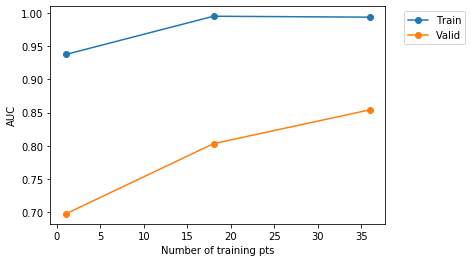

In [43]:
plt.plot(n_pts,aucs_train,'o-',label='Train')
plt.plot(n_pts,aucs_valid,'o-',label='Valid')
plt.xlabel('Number of training pts')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor=(1.04,1),loc='upper left')
plt.show

In [44]:
#testing multiple types of deep learning models

In [ ]:
#CNN

In [46]:
#reshape input to be [samples,time steps,features=1]

X_train_cnn=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_valid_cnn=np.reshape(X_valid,(X_valid.shape[0],X_valid.shape[1],1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)

(80614, 2160, 1)
(28485, 2160, 1)


In [47]:
from keras.layers import Conv1D


In [49]:
model=Sequential()
model.add(Conv1D(filters=120,kernel_size=5,activation='relu',input_shape=(2160,1)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

#compile the model use categorical crossentropy and adma optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [52]:
model.fit(X_train_cnn,y_train,batch_size=32,epochs=2,verbose=1)

Epoch 1/2
80614/80614 [==============================] - 557s 7ms/step - loss: 0.1953 - accuracy: 0.9344
Epoch 2/2
80614/80614 [==============================] - 584s 7ms/step - loss: 0.1199 - accuracy: 0.9652


In [53]:
y_train_preds_cnn=model.predict_proba(X_train_cnn,verbose=1)
y_valid_preds_cnn=model.predict_proba(X_valid_cnn,verbose=1)

28485/28485 [==============================] - 22s 780us/step


In [54]:
print('Train')
print_report(y_train,y_train_preds_cnn,thresh)

print('Valid')
print_report(y_valid,y_valid_preds_cnn,thresh)

Train
AUC:0.992
accuracy:0.961
recall:0.970
precision:0.907
specificity:0.958
prevalence:0.299
 
Valid
AUC:0.888
accuracy:0.803
recall:0.735
precision:0.721
specificity:0.842
prevalence:0.358
 


(0.887610633113553,
 0.8034755134281201,
 0.7346738597351643,
 0.7213714725994413,
 array([0.84182613]))

<h5> BONUS </h5>

In [55]:
#LSTM

In [56]:
from keras.layers import Bidirectional, LSTM

In [58]:
model=Sequential()
model.add(Bidirectional(LSTM(64,input_shape=(X_train_cnn.shape[1],X_train_cnn.shape[2]))))
model.add(Dropout(rate=0.25))
model.add(Dense(1,activation='sigmoid'))

#compile the model use categorical crossentropy and adma optimizer
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [59]:
model.fit(X_train_cnn[:10000],y_train[:10000],batch_size=32,epochs=1,verbose=1)


Epoch 1/1
10000/10000 [==============================] - 853s 85ms/step - loss: 0.5560 - accuracy: 0.7396


In [60]:
y_train_preds_lstm=model.predict_proba(X_train_cnn[:10000],verbose=1)
y_valid_preds_lstm=model.predict_proba(X_valid_cnn,verbose=1)

28485/28485 [==============================] - 501s 18ms/step


In [61]:
print('Train')
print_report(y_train[:10000],y_train_preds_lstm,thresh)

print('Valid')
print_report(y_valid,y_valid_preds_lstm,thresh)

Train
AUC:0.850
accuracy:0.823
recall:0.838
precision:0.807
specificity:0.808
prevalence:0.489
 
Valid
AUC:0.453
accuracy:0.575
recall:0.157
precision:0.313
specificity:0.808
prevalence:0.358
 


(0.45347226084249426,
 0.5748288572933122,
 0.15664541441883276,
 0.3125244618395303,
 array([0.80792783]))

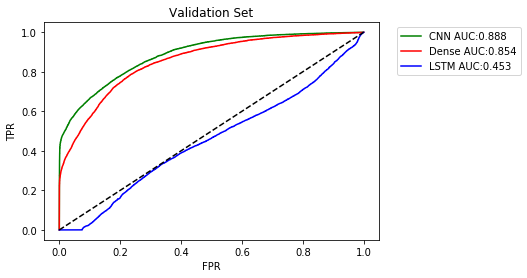

In [80]:
from sklearn.metrics import roc_curve, roc_auc_score


fpr_valid_cnn, tpr_valid_cnn, t_valid_cnn = roc_curve(y_valid, y_valid_preds_cnn)
auc_valid_cnn = roc_auc_score(y_valid, y_valid_preds_cnn)

fpr_valid_dense, tpr_valid_dense, t_valid_dense = roc_curve(y_valid, y_valid_preds_dense)
auc_valid_dense = roc_auc_score(y_valid, y_valid_preds_dense)

fpr_valid_lstm, tpr_valid_lstm, t_valid_lstm = roc_curve(y_valid, y_valid_preds_lstm)
auc_valid_lstm = roc_auc_score(y_valid, y_valid_preds_lstm)

plt.plot(fpr_valid_cnn, tpr_valid_cnn, 'g-', label = 'CNN AUC:%.3f'%auc_valid_cnn)
plt.plot(fpr_valid_dense, tpr_valid_dense, 'r-', label = 'Dense AUC:%.3f'%auc_valid_dense)
plt.plot(fpr_valid_lstm, tpr_valid_lstm, 'b-', label = 'LSTM AUC:%.3f'%auc_valid_lstm)

plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.title('Validation Set')
plt.show()